In [348]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns

Loading dataframes

In [151]:
holidays = pd.read_csv('holidays_events.csv')
oil = pd.read_csv('oil.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
transactions = pd.read_csv('transactions.csv')

In [152]:
oil = oil.rename(columns={'dcoilwtico':'Price'})

Only null values are in the oil dataframe

In [153]:
null_values = oil.isnull().sum()
null_values

date      0
Price    43
dtype: int64

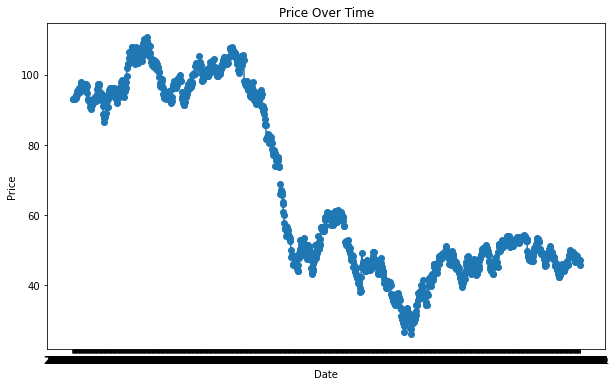

In [154]:
plt.figure(figsize=(10, 6))
plt.plot(oil['date'], oil['Price'], marker='o', linestyle='-')
plt.title('Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(False)
plt.show()

Price changes are somewhat smooth so missing values can be back filled

In [155]:
oil['date'] = pd.to_datetime(oil['date'])

# Fill missing values in 'price' column by taking the next available price
oil['Price'] = oil['Price'].fillna(method='bfill')

Adding oil data to training data

In [156]:
train['date'] = pd.to_datetime(train['date'])

train1 = pd.merge(train, oil, on='date', how='left')

# Fill missing values in the 'Price' column with the corresponding values from the short data frame
train1['Price'] = train1['Price'].fillna(method='ffill')

Encoding all store information before adding to training data

In [157]:
stores.head(20)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [158]:
cities = stores.city.unique()
states = stores.state.unique()
types = stores.type.unique()

In [159]:
city_dict = {city: idx for idx, city in enumerate(cities)}
state_dict = {state: idx for idx, state in enumerate(states)}
type_dict = {type: idx for idx, type in enumerate(types)}

In [160]:
stores['city'] = stores['city'].replace(city_dict)
stores['state'] = stores['state'].replace(state_dict)
stores['type'] = stores['type'].replace(type_dict)

Adding store data and transction data to training data

In [161]:
train2 = pd.merge(train1, stores, on='store_nbr', how='left')

In [162]:
transactions['date'] = pd.to_datetime(transactions['date'])

In [163]:
train3 = pd.merge(train2, transactions[['date', 'store_nbr', 'transactions']], on=['date', 'store_nbr'], how='left')
train3['transactions'] = train3['transactions'].fillna(0)

In [164]:
categories_list = train3.family.unique()
categories_dict = {category: idx for idx, category in enumerate(categories_list)}
train3['family'] = train3['family'].replace(categories_dict)

Now adding holiday data

In [199]:
holidays.type.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [200]:
for index, row in holidays.iterrows():
    if row['transferred']:
        # Change the 'type' value to 'work day'
        holidays.at[index, 'type'] = 'Work Day'
        
        # Find the first row after the current row where 'type' is 'transfer'
        next_transfer_index = holidays.loc[index+1:][holidays['type'] == 'Transfer'].index.min()
        
        # Change the 'type' value of the found row to 'holiday'
        if pd.notnull(next_transfer_index):
            holidays.at[next_transfer_index, 'type'] = 'Holiday'

C:\Users\User\AppData\Local\Temp/ipykernel_6728/2788016115.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  next_transfer_index = holidays.loc[index+1:][holidays['type'] == 'Transfer'].index.min()


In [204]:
holidays.head(5)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [205]:
type_holidays = holidays.type.unique()
locales = holidays.locale.unique()
descriptions = holidays.description.unique()

type_dict_holidays = {type: idx for idx, type in enumerate(type_holidays)}
locales_dict = {state: idx for idx, state in enumerate(locales)}
descriptions_dict = {type: idx for idx, type in enumerate(descriptions)}

In [209]:
holidays['type'] = holidays['type'].replace(type_dict_holidays)
holidays['locale'] = holidays['locale'].replace(locales_dict)
holidays['description'] = holidays['description'].replace(descriptions_dict)

In [231]:
holidays2 = holidays.drop(columns=['transferred','locale_name','locale'])

In [233]:
holidays2['date'] = pd.to_datetime(holidays2['date'])

In [235]:
train4 = pd.merge(train3, holidays2, on='date', how='left')

In [242]:
train4['type_y'] = train4['type_y'].fillna(1)
train4['description'] = train4['description'].fillna(103)

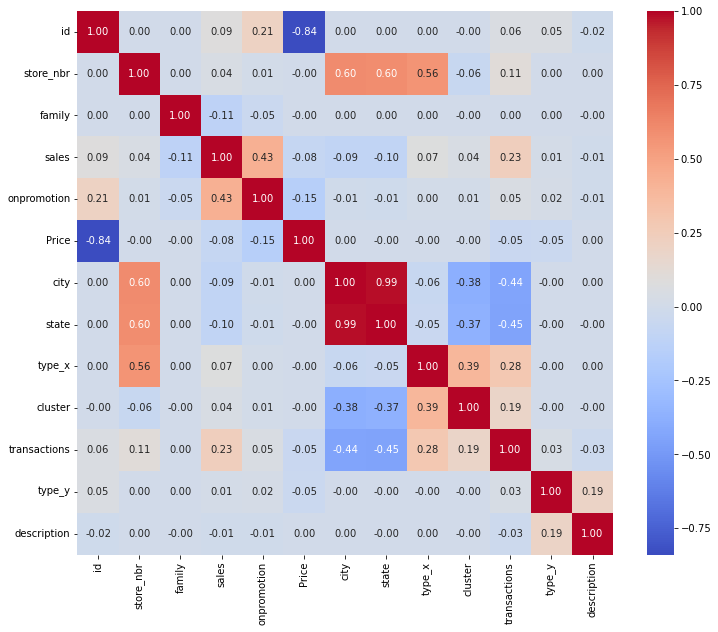

In [265]:
correlation_matrix = train4.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [270]:
train5 = train4.rename(columns={'type_x':'store_type','family':'product_type'})

In [363]:
X = train5.drop(columns=['id','date','sales','type_y','description','transactions'])
y = train5.sales

one_hot_encoded = pd.get_dummies(X['product_type'], prefix='product')
X2 = pd.concat([X, one_hot_encoded], axis=1)
X2.drop('product_type', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X2,y,test_size=0.15)

In [350]:
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, make_scorer

In [386]:
def rmsle_metric(y_true, y_pred):
    y_true_log = np.log1p(y_true)
    y_pred_log = np.log1p(y_pred)
    return np.sqrt(np.mean(np.square(y_true_log - y_pred_log)))

# Make a scorer from the custom RMSLE metric
rmsle_scorer = make_scorer(rmsle_metric, greater_is_better=False)

param_grid = {
    'n_estimators': [300],
    'max_depth': [7],
    'learning_rate': [0.2]
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring=rmsle_scorer, cv=3)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

# Evaluate the performance using mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Best Parameters:", best_params)
print(rmsle_metric(y_test, y_pred))

SyntaxError: invalid syntax (Temp/ipykernel_6728/371613362.py, line 36)

In [385]:
rmsle_metric(y_test, y_pred)

1.5199826938816217

Now need to prep test data

In [290]:
test['date'] = pd.to_datetime(test['date'])

test1 = pd.merge(test, oil, on='date', how='left')

# Fill missing values in the 'Price' column with the corresponding values from the short data frame
test1['Price'] = test1['Price'].fillna(method='ffill')

In [292]:
test2 = pd.merge(test1, stores, on='store_nbr', how='left')

In [305]:
test2['family'] = test2['family'].replace(categories_dict)

In [318]:
test3 = test2.rename(columns={'type':'store_type','family':'product_type'})

In [320]:
X_sub = test3.drop(columns=['id','date'])

In [365]:
one_hot_encoded = pd.get_dummies(X_sub['product_type'], prefix='product')
X2_sub = pd.concat([X_sub, one_hot_encoded], axis=1)
X2_sub.drop('product_type', axis=1, inplace=True)

In [370]:
xgb_model_sub = xgb.XGBRegressor(learning_rate=0.2, max_depth=7,n_estimators=300)

# Train the model on the training set
xgb_model_sub.fit(X2, y)

# Make predictions on the test set
y_pred_sub = xgb_model_sub.predict(X2_sub)


In [371]:
y_out = []

for value in y_pred_sub:
    y_out.append(max(0, value))

In [372]:
y_df = pd.DataFrame(y_out)
y_df.rename(columns={0:'sales'},inplace=True)

In [373]:
test_id = test.id
id_df = pd.DataFrame(test_id)

In [374]:
combined_df = pd.concat([id_df, y_df], axis=1)

In [375]:
combined_df.to_csv('XGBRegressor3.csv', index=False)